In [1]:
import os
os.chdir("..")

In [2]:
from skin_lesion_cad.utils.data_utils import get_class
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import functools as ft
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from skopt import BayesSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import xgboost as xgb
import time
import warnings
from pathlib import Path
mpl.rcParams['figure.dpi'] = 200


In [3]:
feature_dir = "data/processed/features"
CHALLENGE = "chall1"

In [4]:

def read_feats(color="raw"):
    save_path = Path("data/processed/features")

    glcm_df_train = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_train_glcm.feather"))
    lbp_df_train = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_train_lbp.feather"))
    color_df_raw_train = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_train_color_raw.feather"))
    color_df_ms_train = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_train_color_meanshift.feather"))

    glcm_df_val = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_val_glcm.feather"))
    lbp_df_val = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_val_lbp.feather"))
    color_df_raw_val = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_val_color_raw.feather"))
    color_df_ms_val = pd.read_feather(
        save_path/Path(f"{CHALLENGE}_val_color_meanshift.feather"))

    dfs = [glcm_df_train, lbp_df_train, color_df_raw_train]
    all_feat_raw_train = ft.reduce(
        lambda left, right: pd.merge(left, right, on='image'), dfs)

    dfs = [glcm_df_train, lbp_df_train, color_df_ms_train]
    all_feat_ms_train = ft.reduce(
        lambda left, right: pd.merge(left, right, on='image'), dfs)

    dfs = [glcm_df_val, lbp_df_val, color_df_raw_val]
    all_feat_raw_val = ft.reduce(
        lambda left, right: pd.merge(left, right, on='image'), dfs)

    dfs = [glcm_df_val, lbp_df_val, color_df_ms_val]
    all_feat_ms_val = ft.reduce(
        lambda left, right: pd.merge(left, right, on='image'), dfs)
    if color == "raw":
        return all_feat_raw_train, all_feat_raw_val
    elif color == "meanshift":
        return all_feat_ms_train, all_feat_ms_val


In [5]:

color = "raw"
all_feat_train, all_feat_val = read_feats("raw")

X = all_feat_train.drop(columns='image')
y = all_feat_train['image'].apply(get_class,chall=CHALLENGE)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42)
X_test = all_feat_val.drop(columns='image')
y_test = all_feat_val['image'].apply(get_class, chall=CHALLENGE)


In [6]:
X_train.columns

Index(['contrast_0', 'contrast_1', 'contrast_2', 'contrast_3', 'contrast_4',
       'contrast_5', 'contrast_6', 'contrast_7', 'contrast_8', 'contrast_9',
       ...
       'YCrCb_C_entrp', 'YCrCb_C_unq', 'YCrCb_r_mean', 'YCrCb_r_std',
       'YCrCb_r_skew', 'YCrCb_r_kurt', 'YCrCb_r_max', 'YCrCb_r_min',
       'YCrCb_r_entrp', 'YCrCb_r_unq'],
      dtype='object', length=366)

In [7]:
X[np.isnan(X)] = 0
X[np.isinf(X)] = 0

X_train[np.isnan(X_train)] = 0
X_train[np.isinf(X_train)] = 0
X_val[np.isnan(X_val)] = 0
X_val[np.isinf(X_val)] = 0
X_test[np.isnan(X_test)] = 0
X_test[np.isinf(X_test)] = 0


In [62]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
# X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [46]:


#dictionary for collecting results
results_dict = {}

#obtaining default parameters by calling .fit() to XGBoost model instance
xgbc0 = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False)
xgbc0.fit(X, y)

#extracting default parameters from benchmark model
default_params = {}
gparams = xgbc0.get_params()

#default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
for key in gparams.keys():
    gp = gparams[key]
    default_params[key] = [gp]

#benchmark model. Grid search is not performed, since only single values are provided as parameter grid.
#However, cross-validation is still executed
clf0 = GridSearchCV(estimator=xgbc0, scoring='accuracy',
                    param_grid=default_params, return_train_score=True, verbose=1, cv=3)
clf0.fit(X, y.values.ravel())

#results dataframe
df = pd.DataFrame(clf0.cv_results_)

#predictions - inputs to confusion matrix
train_predictions = clf0.predict(X)
# val_predictions = clf0.predict(X_val)
test_predictions = clf0.predict(X_test)

#confusion matrices
cfm_train = confusion_matrix(y, train_predictions)
# cfm_test = confusion_matrix(y_val, val_predictions)
cfm_test = confusion_matrix(y_test, test_predictions)

#accuracy scores
accs_train = accuracy_score(y, train_predictions)
# accs_test = accuracy_score(y_val, val_predictions)
accs_test = accuracy_score(y_test, test_predictions)

#F1 scores for each train/test label
f1s_train_p1 = f1_score(y, train_predictions, pos_label=1)
f1s_train_p0 = f1_score(y, train_predictions, pos_label=0)
# f1s_test_p1 = f1_score(y_val, val_predictions, pos_label=1)
f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)
f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1)
f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)

#Area Under the Receiver Operating Characteristic Curve
test_ras = roc_auc_score(y_test, clf0.predict_proba(X_test)[:, 1])
unseen_ras = roc_auc_score(
    y_test, clf0.predict_proba(X_test)[:, 1])

#best parameters
bp = clf0.best_params_

#storing computed values in results dictionary
results_dict['xgbc0'] = {'iterable_parameter': np.nan,
                         'classifier': deepcopy(clf0),
                         'cv_results': df.copy(),
                         'cfm_train': cfm_train,
                         'cfm_test': cfm_test,
                        #  'cfm_unseen': cfm_unseen,
                         'train_accuracy': accs_train,
                         'test_accuracy': accs_test,
                        #  'unseen_accuracy': accs_test,
                         'train F1-score label 1': f1s_train_p1,
                         'train F1-score label 0': f1s_train_p0,
                         'test F1-score label 1': f1s_test_p1,
                         'test F1-score label 0': f1s_test_p0,
                        #  'unseen F1-score label 1': f1s_test_p1,
                        #  'unseen F1-score label 0': f1s_test_p0,
                         'test roc auc score': test_ras,
                        #  'unseen roc auc score': unseen_ras,
                         'best_params': bp}


Fitting 3 folds for each of 1 candidates, totalling 3 fits


# Parameters tuning

In [47]:
#creating deepcopy of default parameters before manipulations
params = deepcopy(default_params)

#setting grid of selected parameters for iteration
param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}


In [48]:
#start time
t0 = time.time()
#No. of jobs
gcvj = np.cumsum([len(x) for x in param_grid.values()])[-1]

#iteration loop. Each selected parameter iterated separately
for i,grid_key in enumerate(param_grid.keys()):
    
    #variable for measuring iteration time
    loop_start = time.time()
       
    #creating param_grid argument for GridSearchCV:
    #listing grid values of current iterable parameter and wrapping non-iterable parameter single values in list
    for param_key in params.keys():
        if param_key == grid_key:
            params[param_key] = param_grid[grid_key]
        else:
            #use best parameters of last iteration
            try:
                param_value = [clf.best_params_[param_key]]
                params[param_key] = param_value
            #use benchmark model parameters for first iteration
            except:
                param_value = [clf0.best_params_[param_key]]
                params[param_key] = param_value
    
    #classifier instance of current iteration
    xgbc = xgb.XGBClassifier(**default_params)
    
    #GridSearch instance of current iteration
    clf = GridSearchCV(estimator=xgbc, param_grid=params, scoring='accuracy', return_train_score=True, verbose=1, cv=3)
    clf.fit(X, y.values.ravel())
    
    #results dataframe
    df = pd.DataFrame(clf.cv_results_)
    
    #predictions - inputs to confusion matrix
    train_predictions = clf.predict(X)
    test_predictions = clf.predict(X_test)
    # unseen_predictions = clf.predict(df_test.iloc[:,1:])
    
    #confusion matrices
    cfm_train = confusion_matrix(y, train_predictions)
    cfm_test = confusion_matrix(y_test, test_predictions)
    # cfm_unseen = confusion_matrix(df_test.iloc[:,:1], unseen_predictions)
    
    #accuracy scores
    accs_train = accuracy_score(y, train_predictions)
    accs_test = accuracy_score(y_test, test_predictions)
    # accs_unseen = accuracy_score(df_test.iloc[:,:1], unseen_predictions)
    
    #F1 scores for each train/test label
    f1s_train_p1 = f1_score(y, train_predictions, pos_label=1)
    f1s_train_p0 = f1_score(y, train_predictions, pos_label=0)
    f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1)
    f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)
    # f1s_unseen_p1 = f1_score(df_test.iloc[:,:1], unseen_predictions, pos_label=1)
    # f1s_unseen_p0 = f1_score(df_test.iloc[:,:1], unseen_predictions, pos_label=0)
    
    #Area Under the Receiver Operating Characteristic Curve
    test_ras = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    # unseen_ras = roc_auc_score(df_test.iloc[:,:1], clf.predict_proba(df_test.iloc[:,1:])[:,1])
    
    #best parameters
    bp = clf.best_params_
    
    #storing computed values in results dictionary
    results_dict[f'xgbc{i+1}'] = {'iterable_parameter': grid_key,
                                  'classifier': deepcopy(clf),
                                  'cv_results': df.copy(),
                                  'cfm_train': cfm_train,
                                  'cfm_test': cfm_test,
                                #   'cfm_unseen': cfm_unseen,
                                  'train_accuracy': accs_train,
                                  'test_accuracy': accs_test,
                                #   'unseen_accuracy': accs_unseen,
                                  'train F1-score label 1': f1s_train_p1,
                                  'train F1-score label 0': f1s_train_p0,
                                  'test F1-score label 1': f1s_test_p1,
                                  'test F1-score label 0': f1s_test_p0,
                                #   'unseen F1-score label 1': f1s_unseen_p1,
                                #   'unseen F1-score label 0': f1s_unseen_p0,
                                  'test roc auc score': test_ras,
                                #   'unseen roc auc score': unseen_ras,
                                  'best_params': bp}
    
    #variable for measuring iteration time
    elapsed_time = time.time() - loop_start
    print(f'iteration #{i+1} finished in: {elapsed_time} seconds')

#stop time
t1 = time.time()

#elapsed time
gcvt = t1 - t0


Fitting 3 folds for each of 13 candidates, totalling 39 fits
iteration #1 finished in: 196.11142826080322 seconds
Fitting 3 folds for each of 12 candidates, totalling 36 fits
iteration #2 finished in: 332.98812913894653 seconds
Fitting 3 folds for each of 10 candidates, totalling 30 fits
iteration #3 finished in: 283.7359199523926 seconds
Fitting 3 folds for each of 7 candidates, totalling 21 fits
iteration #4 finished in: 219.26974272727966 seconds
Fitting 3 folds for each of 13 candidates, totalling 39 fits
iteration #5 finished in: 277.10455083847046 seconds
Fitting 3 folds for each of 13 candidates, totalling 39 fits
iteration #6 finished in: 365.36397528648376 seconds


In [49]:
results_dict.keys()


dict_keys(['xgbc0', 'xgbc1', 'xgbc2', 'xgbc3', 'xgbc4', 'xgbc5', 'xgbc6'])

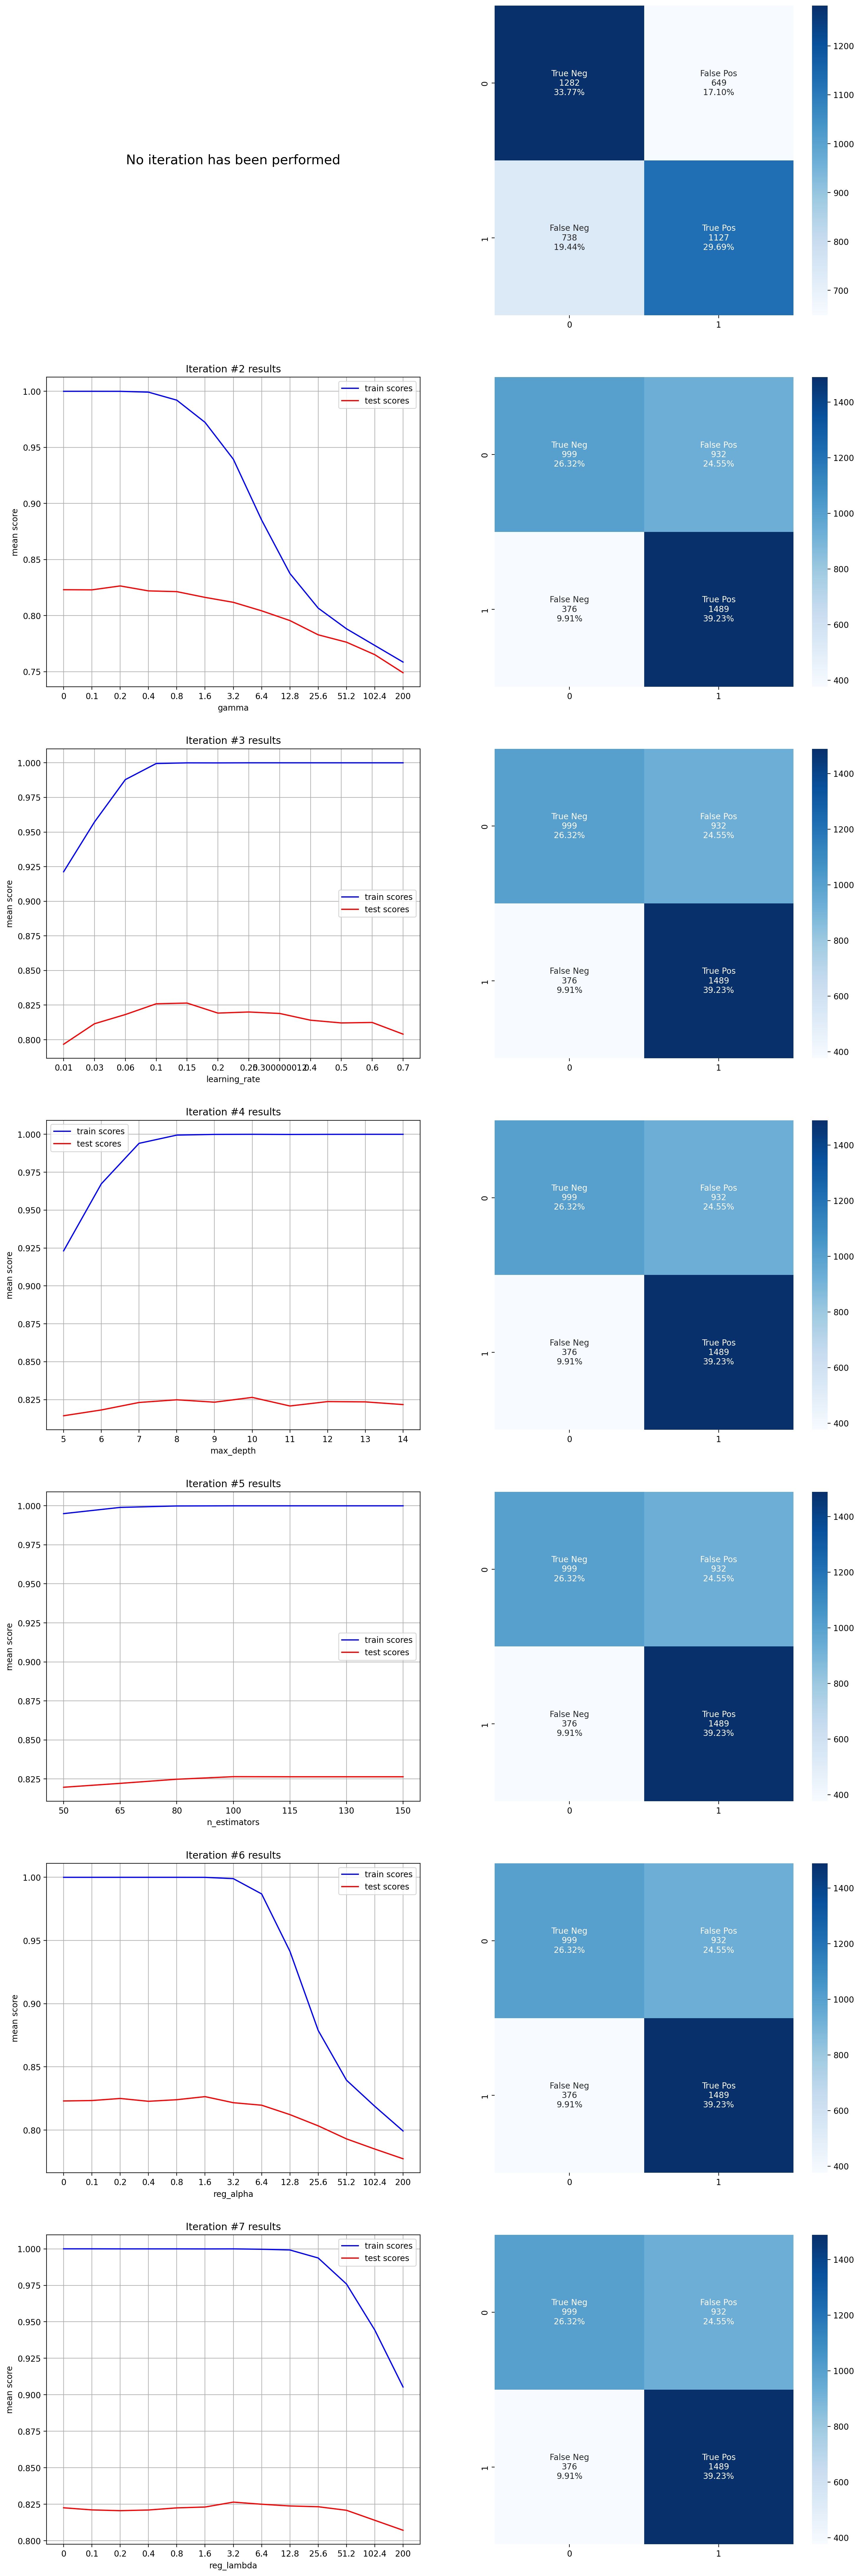

In [50]:
#number of rows depend on number of iterations
nrows = len(results_dict.keys())

#standard group names for confusion matrices
group_names = ['True Neg','False Pos','False Neg','True Pos']

#creating figure
f, axes = plt.subplots(nrows,2,figsize=(18,8*nrows));

#iteratively plotting train/test accuracy scores and test confusion matrix
for i,ax in enumerate(axes):
    
    #current key of results dictionary
    ckey = list(results_dict.keys())[i] 
    
    #plotting scores for models other than the benchark model
    if ckey != 'xgbc0':
        x1 = results_dict[ckey]['cv_results'].loc[:,'mean_train_score']
        x2 = results_dict[ckey]['cv_results'].loc[:,'mean_test_score']
        
        ax[0].plot(x1, label='train scores', color='blue');
        ax[0].plot(x2, label='test scores', color='red');
        ax[0].set_title(f'Iteration #{i+1} results');
               
        ax[0].set_xticks(list(range(0,len([x[results_dict[ckey]['iterable_parameter']] for x in results_dict[ckey]['cv_results']['params']]))));
        ax[0].set_xticklabels(sorted([x[results_dict[ckey]['iterable_parameter']] for x in results_dict[ckey]['cv_results']['params']]));
    
        ax[0].grid('major');
        ax[0].legend();
        ax[0].set_xlabel(results_dict[ckey]['iterable_parameter'])
        ax[0].set_ylabel('mean score');
    
    #leaving scores plot blank for benchmark model
    else:
        ax[0].axis('off')
        ax[0].text(x=0.5, y=0.5, s='No iteration has been performed', fontsize=16, va='center', ha='center')
    
    #computing variables for specific confusion matrix
    group_counts = ["{0:0.0f}".format(value) for value in results_dict[ckey]['cfm_test'].flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in results_dict[ckey]['cfm_test'].flatten()/np.sum(results_dict[ckey]['cfm_test'])]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    #plotting confusion matrix
    sns.heatmap(results_dict[ckey]['cfm_test'], annot=labels, fmt='', cmap='Blues', ax=ax[1])
    
plt.show();


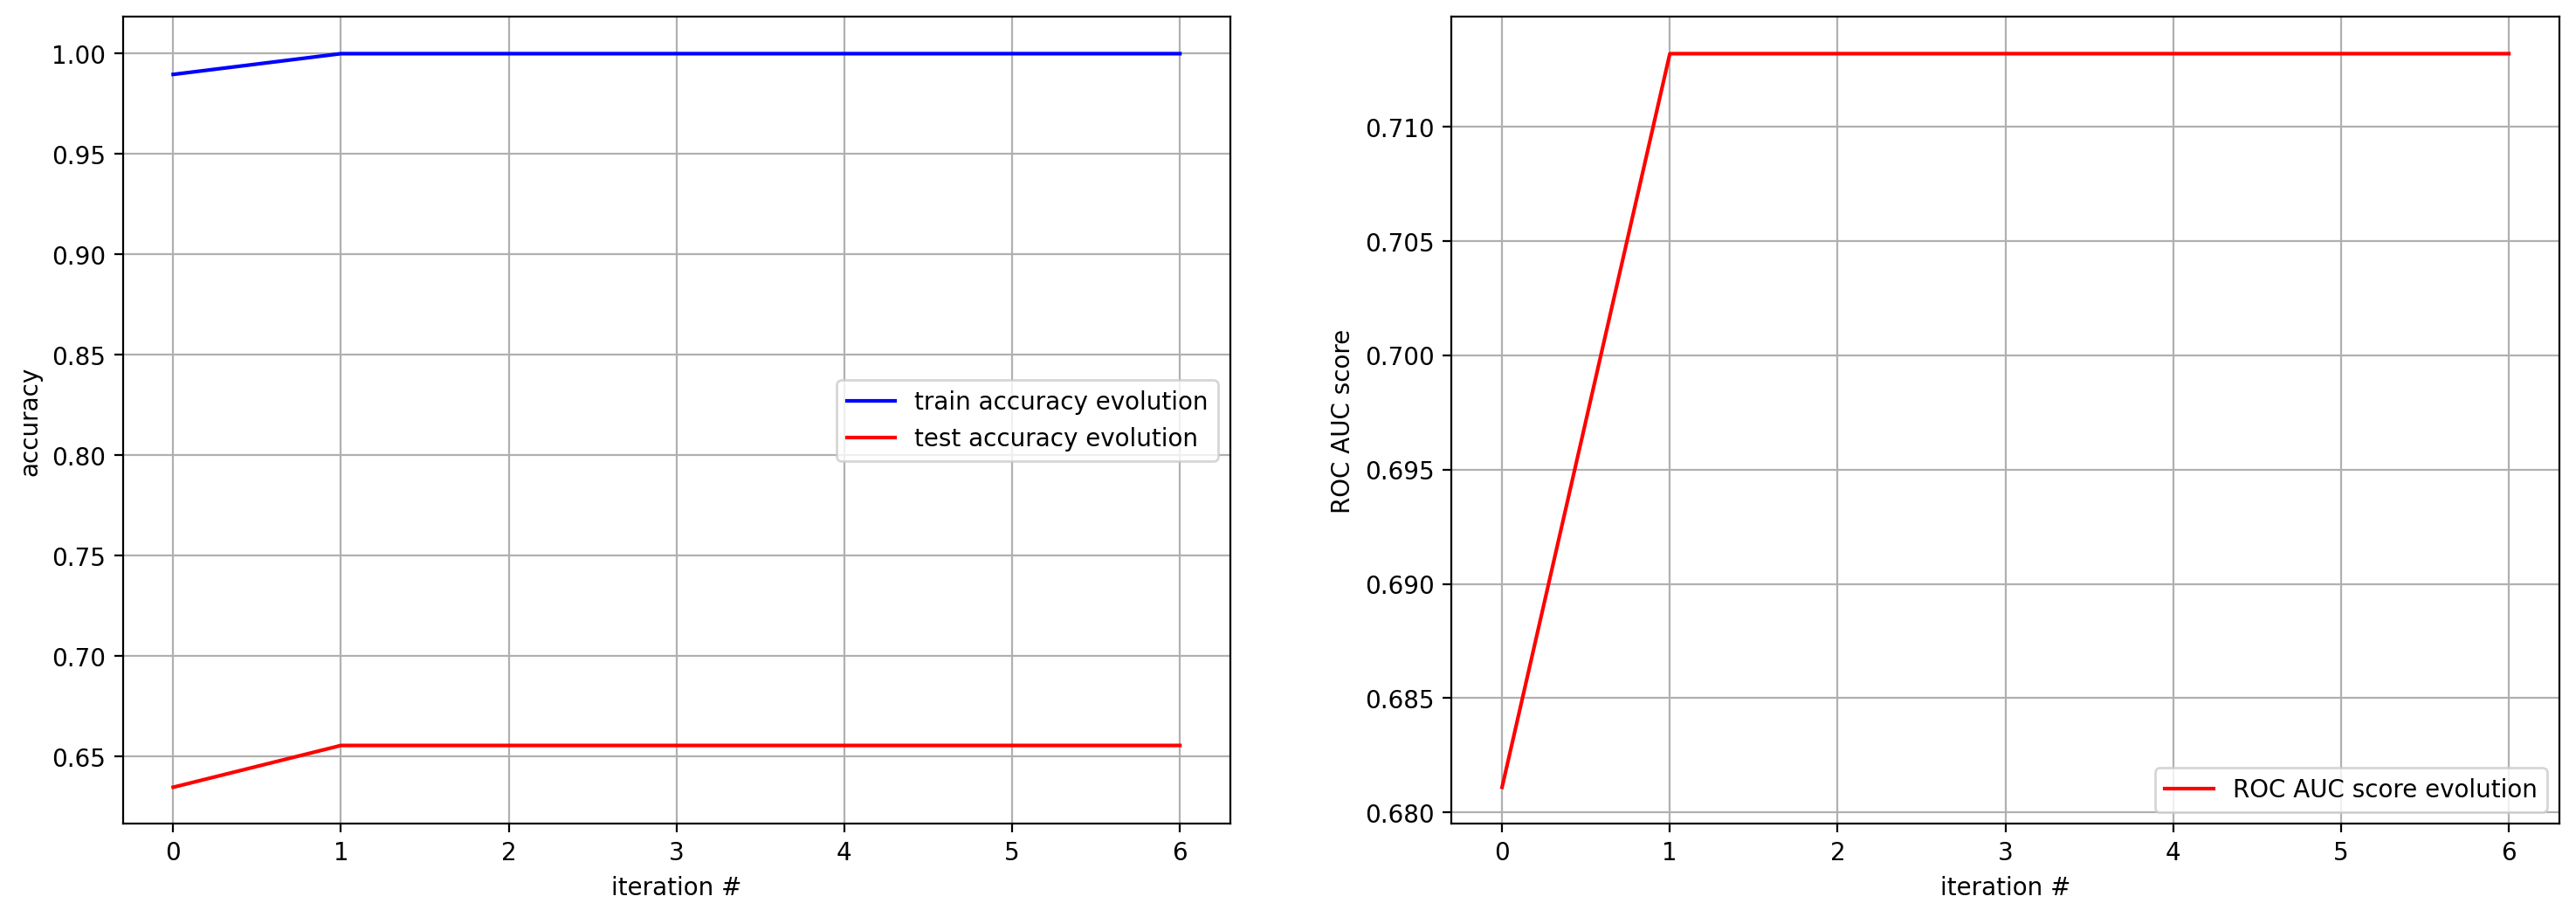

In [51]:
f, axes = plt.subplots(1, 2, figsize=(18, 6))

#plotting evolution of train/test accuracy scores for subsequent iterations
axes[0].plot([results_dict[key]['train_accuracy'] for key in results_dict.keys(
)], label='train accuracy evolution', color='blue')
axes[0].plot([results_dict[key]['test_accuracy']
             for key in results_dict.keys()], label='test accuracy evolution', color='red')

#setting labels, drawing legend and major grid
axes[0].set_xlabel('iteration #')
axes[0].set_ylabel('accuracy')
axes[0].legend()
axes[0].grid('major')

#plotting evolution of test ROC AUC scores for subsequent iterations
axes[1].plot([results_dict[key]['test roc auc score']
             for key in results_dict.keys()], label='ROC AUC score evolution', color='red')

#setting labels, drawing legend and major grid
axes[1].set_xlabel('iteration #')
axes[1].set_ylabel('ROC AUC score')
axes[1].legend()
axes[1].grid('major')

plt.show()


In [52]:
# #start time
# t0 = time.time()

# #No. of jobs
# rcvj = gcvj

# #unwrapping list values of default parameters
# default_params_xgb = {}

# for key in default_params.keys():
#     default_params_xgb[key] = default_params[key][0]

# #providing default parameters to xgbc model, before randomized search cross-validation
# xgbc = xgb.XGBClassifier(**default_params_xgb)

# #Executing Randomized Search
# clf = RandomizedSearchCV(estimator=xgbc, param_distributions=param_grid, scoring='accuracy', return_train_score=True, verbose=3, cv=3, n_iter=rcvj)
# clf.fit(X_train, y_train.values.ravel())
    
# #results dataframe
# df = pd.DataFrame(clf.cv_results_)
    
# #predictions - inputs to confusion matrix
# train_predictions = clf.predict(X_train)
# test_predictions = clf.predict(X_test)
# # unseen_predictions = clf.predict(df_test.iloc[:,1:])
    
# #confusion matrices
# cfm_train = confusion_matrix(y_train, train_predictions)
# cfm_test = confusion_matrix(y_test, test_predictions)
# # cfm_unseen = confusion_matrix(df_test.iloc[:,:1], unseen_predictions)
    
# #accuracy scores
# accs_train = accuracy_score(y_train, train_predictions)
# accs_test = accuracy_score(y_test, test_predictions)
# # accs_unseen = accuracy_score(df_test.iloc[:,:1], unseen_predictions)
    
# #F1 scores for each train/test label
# f1s_train_p1 = f1_score(y_train, train_predictions, pos_label=1)
# f1s_train_p0 = f1_score(y_train, train_predictions, pos_label=0)
# f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1)
# f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)
# # f1s_unseen_p1 = f1_score(df_test.iloc[:,:1], unseen_predictions, pos_label=1)
# # f1s_unseen_p0 = f1_score(df_test.iloc[:,:1], unseen_predictions, pos_label=0)
    
# #Area Under the Receiver Operating Characteristic Curve
# test_ras = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
# # unseen_ras = roc_auc_score(df_test.iloc[:,:1], clf.predict_proba(df_test.iloc[:,1:])[:,1])
    
# #best parameters
# bp = clf.best_params_
    
# #storing computed values in results dictionary
# results_dict['xgbc_rcv'] = {'classifier': deepcopy(clf),
#                             'cv_results': df.copy(),
#                             'cfm_train': cfm_train,
#                             'cfm_test': cfm_test,
#                             # 'cfm_unseen': cfm_unseen,
#                             'train_accuracy': accs_train,
#                             'test_accuracy': accs_test,
#                             # 'unseen_accuracy': accs_unseen,
#                             'train F1-score label 1': f1s_train_p1,
#                             'train F1-score label 0': f1s_train_p0,
#                             'test F1-score label 1': f1s_test_p1,
#                             'test F1-score label 0': f1s_test_p0,
#                             # 'unseen F1-score label 1': f1s_unseen_p1,
#                             # 'unseen F1-score label 0': f1s_unseen_p0,
#                             'test roc auc score': test_ras,
#                             # 'unseen roc auc score': unseen_ras,
#                             'best_params': bp}

# #stop time
# t1 = time.time()

# #elapsed time
# rcvt = t1 - t0


In [53]:
#start time
# t0 = time.time()

# #No. of jobs
# bcvj = int(gcvj)

# #unwrapping list values of default parameters
# default_params_xgb = {}

# for key in default_params.keys():
#     default_params_xgb[key] = default_params[key][0]

# #providing default parameters to xgbc model, before randomized search cross-validation
# xgbc = xgb.XGBClassifier(**default_params_xgb)

# clf = BayesSearchCV(estimator=xgbc, search_spaces=param_grid, n_iter=bcvj, scoring='accuracy', cv=3, return_train_score=True, verbose=3)
# clf.fit(X_train, y_train.values.ravel())

# #results dataframe
# df = pd.DataFrame(clf.cv_results_)
    
# #predictions - inputs to confusion matrix
# train_predictions = clf.predict(X_train)
# test_predictions = clf.predict(X_test)
# # unseen_predictions = clf.predict(df_test.iloc[:,1:])
    
# #confusion matrices
# cfm_train = confusion_matrix(y_train, train_predictions)
# cfm_test = confusion_matrix(y_test, test_predictions)
# # cfm_unseen = confusion_matrix(df_test.iloc[:,:1], unseen_predictions)
    
# #accuracy scores
# accs_train = accuracy_score(y_train, train_predictions)
# accs_test = accuracy_score(y_test, test_predictions)
# # accs_unseen = accuracy_score(df_test.iloc[:,:1], unseen_predictions)
    
# #F1 scores for each train/test label
# f1s_train_p1 = f1_score(y_train, train_predictions, pos_label=1)
# f1s_train_p0 = f1_score(y_train, train_predictions, pos_label=0)
# f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1)
# f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)
# # f1s_unseen_p1 = f1_score(df_test.iloc[:,:1], unseen_predictions, pos_label=1)
# # f1s_unseen_p0 = f1_score(df_test.iloc[:,:1], unseen_predictions, pos_label=0)
    
# #Area Under the Receiver Operating Characteristic Curve
# test_ras = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
# # unseen_ras = roc_auc_score(df_test.iloc[:,:1], clf.predict_proba(df_test.iloc[:,1:])[:,1])
    
# #best parameters
# bp = clf.best_params_
    
# #storing computed values in results dictionary
# results_dict['xgbc_bcv'] = {'classifier': deepcopy(clf),
#                             'cv_results': df.copy(),
#                             'cfm_train': cfm_train,
#                             'cfm_test': cfm_test,
#                             # 'cfm_unseen': cfm_unseen,
#                             'train_accuracy': accs_train,
#                             'test_accuracy': accs_test,
#                             # 'unseen_accuracy': accs_unseen,
#                             'train F1-score label 1': f1s_train_p1,
#                             'train F1-score label 0': f1s_train_p0,
#                             'test F1-score label 1': f1s_test_p1,
#                             'test F1-score label 0': f1s_test_p0,
#                             # 'unseen F1-score label 1': f1s_unseen_p1,
#                             # 'unseen F1-score label 0': f1s_unseen_p0,
#                             'test roc auc score': test_ras,
#                             # 'unseen roc auc score': unseen_ras,
#                             'best_params': bp}

# #stop time
# t1 = time.time()

# #elapsed time
# bcvt = t1 - t0


In [54]:
#printing benchmark, iterative grid search and randomized search ROC AUC / accuracy scores (test data set)
print(
    f"Benchmark AUC/accuracy score: {np.round(results_dict['xgbc0']['test roc auc score'],4)} / {np.round(results_dict['xgbc0']['test_accuracy'],4)}")
print(
    f"Coordinate descent AUC/accuracy score: {np.round(results_dict['xgbc3']['test roc auc score'],4)} / {np.round(results_dict['xgbc3']['test_accuracy'],4)} @ {np.round(gcvt/60,2)} minutes and {gcvj} jobs")
# print(
#     f"Randomized search AUC/accuracy score: {np.round(results_dict['xgbc_rcv']['test roc auc score'],4)} / {np.round(results_dict['xgbc_rcv']['test_accuracy'],4)} @ {np.round(rcvt/60,2)} minutes and {rcvj} jobs")
# print(
#     f"Bayes search AUC/accuracy score: {np.round(results_dict['xgbc_bcv']['test roc auc score'],4)} / {np.round(results_dict['xgbc_bcv']['test_accuracy'],4)} @ {np.round(bcvt/60,2)} minutes and {bcvj} jobs")
print("")

#computing expected time of executing exhaustive grid search
jobs = np.cumprod([len(x) for x in param_grid])[-1]
et = jobs * gcvt / gcvj
print(
    f"Expected time of executing exhaustive grid search with 3-fold cross-validation: {int(et/60)} minutes and {jobs} jobs")


Benchmark AUC/accuracy score: 0.6811 / 0.6346
Coordinate descent AUC/accuracy score: 0.7132 / 0.6554 @ 27.91 minutes and 68 jobs

Expected time of executing exhaustive grid search with 3-fold cross-validation: 259313 minutes and 631800 jobs


In [59]:
best_params = results_dict['xgbc3']['best_params']
best_params.update({'gamma': 0.4,
                    'learning_rate': 0.15,
                    'max_depth': 10,
                    'n_estimators': 100,
                    'reg_alpha': 1.6,
                    'reg_lambda': 3.2})


In [63]:
best_params

{'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'auc',
 'gamma': 0.4,
 'gpu_id': -1,
 'grow_policy': 'lossguide',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.15,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 10,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'objective': 'binary:logistic',
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 1.6,
 'reg_lambda': 3.2,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'hist',
 'use_label_encoder': False,
 'validate_parameters': 1,
 'verbosity': None}

In [60]:
xgb_best = xgb.XGBClassifier(**results_dict['xgbc3']['best_params'])
xgb_best.fit(X, y.values.ravel())
#predictions - inputs to confusion matrix
train_predictions = xgb_best.predict(X)
test_predictions = xgb_best.predict(X_test)
# unseen_predictions = clf.predict(df_test.iloc[:,1:])

#confusion matrices
cfm_train = confusion_matrix(y, train_predictions)
cfm_test = confusion_matrix(y_test, test_predictions)
# cfm_unseen = confusion_matrix(df_test.iloc[:,:1], unseen_predictions)

#accuracy scores
accs_train = accuracy_score(y, train_predictions)
accs_test = accuracy_score(y_test, test_predictions)
print(accs_train)
print(accs_test)


0.9988153998025666
0.6628029504741834


In [61]:
xgb_best = xgb.XGBClassifier(**best_params)
xgb_best.fit(X, y.values.ravel())
#predictions - inputs to confusion matrix
train_predictions = xgb_best.predict(X)
test_predictions = xgb_best.predict(X_test)
# unseen_predictions = clf.predict(df_test.iloc[:,1:])

#confusion matrices
cfm_train = confusion_matrix(y, train_predictions)
cfm_test = confusion_matrix(y_test, test_predictions)
# cfm_unseen = confusion_matrix(df_test.iloc[:,:1], unseen_predictions)

#accuracy scores
accs_train = accuracy_score(y, train_predictions)
accs_test = accuracy_score(y_test, test_predictions)
print(accs_train)
print(accs_test)


0.9988153998025666
0.6628029504741834


[0.0020405  0.00254327 0.00386465 0.00252532 0.0029696  0.00369236
 0.00416938 0.00358882 0.00340391 0.00180066 0.00260551 0.00348857
 0.00261081 0.00265571 0.00326277 0.00199138 0.0040179  0.00247121
 0.00200626 0.00250821 0.00205962 0.00286737 0.00274761 0.00298027
 0.00419735 0.00183034 0.00289406 0.00123967 0.00354854 0.00319176
 0.00124169 0.00276647 0.00345259 0.00280317 0.0025178  0.00165444
 0.00396987 0.0032473  0.00355039 0.0065164  0.00225365 0.00113757
 0.00088953 0.00196582 0.00512772 0.00259098 0.0013639  0.00201053
 0.00120898 0.00109178 0.00388954 0.0026719  0.00202692 0.00076787
 0.00352044 0.00436075 0.00228497 0.00189731 0.00216103 0.002978
 0.00493598 0.00203103 0.00165877 0.00134034 0.00308777 0.0024423
 0.00190226 0.00354912 0.         0.00744309 0.00074647 0.0006105
 0.00433015 0.00080082 0.00519987 0.00086194 0.0034882  0.00115878
 0.00210017 0.0022644  0.00182703 0.00301088 0.00311164 0.00186856
 0.00199637 0.00353443 0.0032728  0.00226173 0.0017425  0.00296068

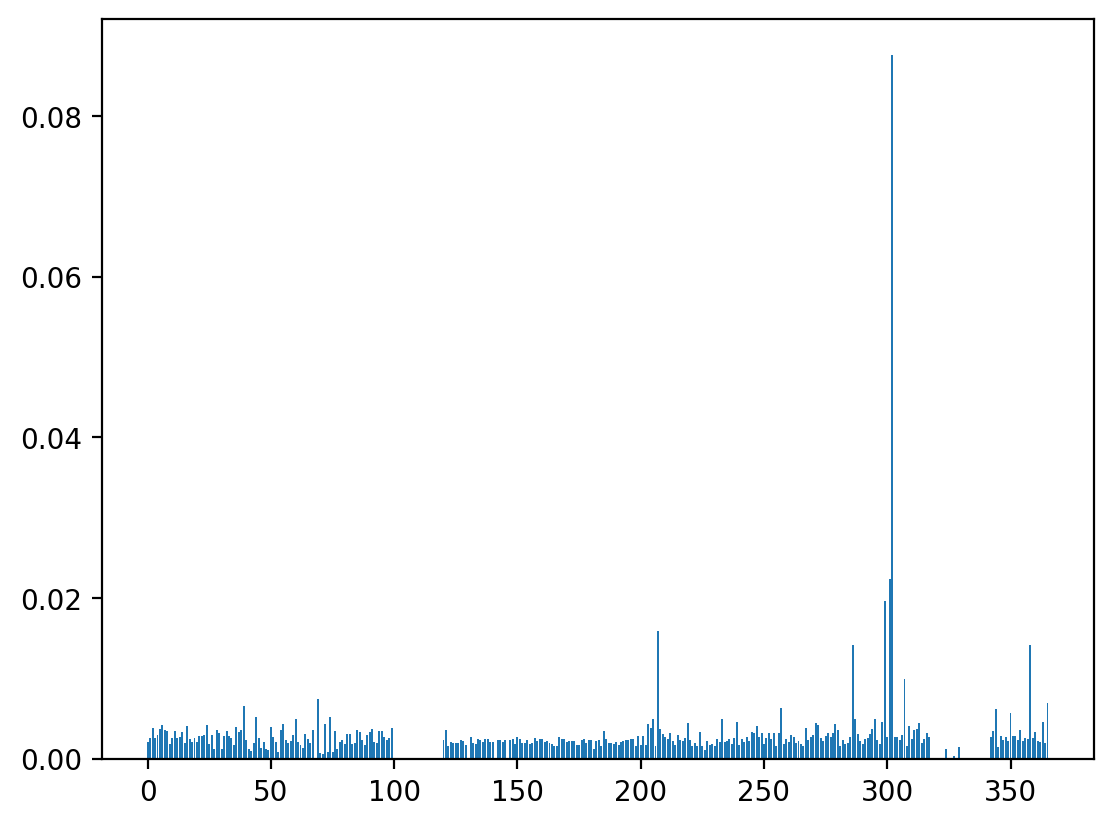

In [29]:
print(xgb_best.feature_importances_)
# plot
plt.bar(range(len(xgb_best.feature_importances_)),
           xgb_best.feature_importances_)
plt.show()


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

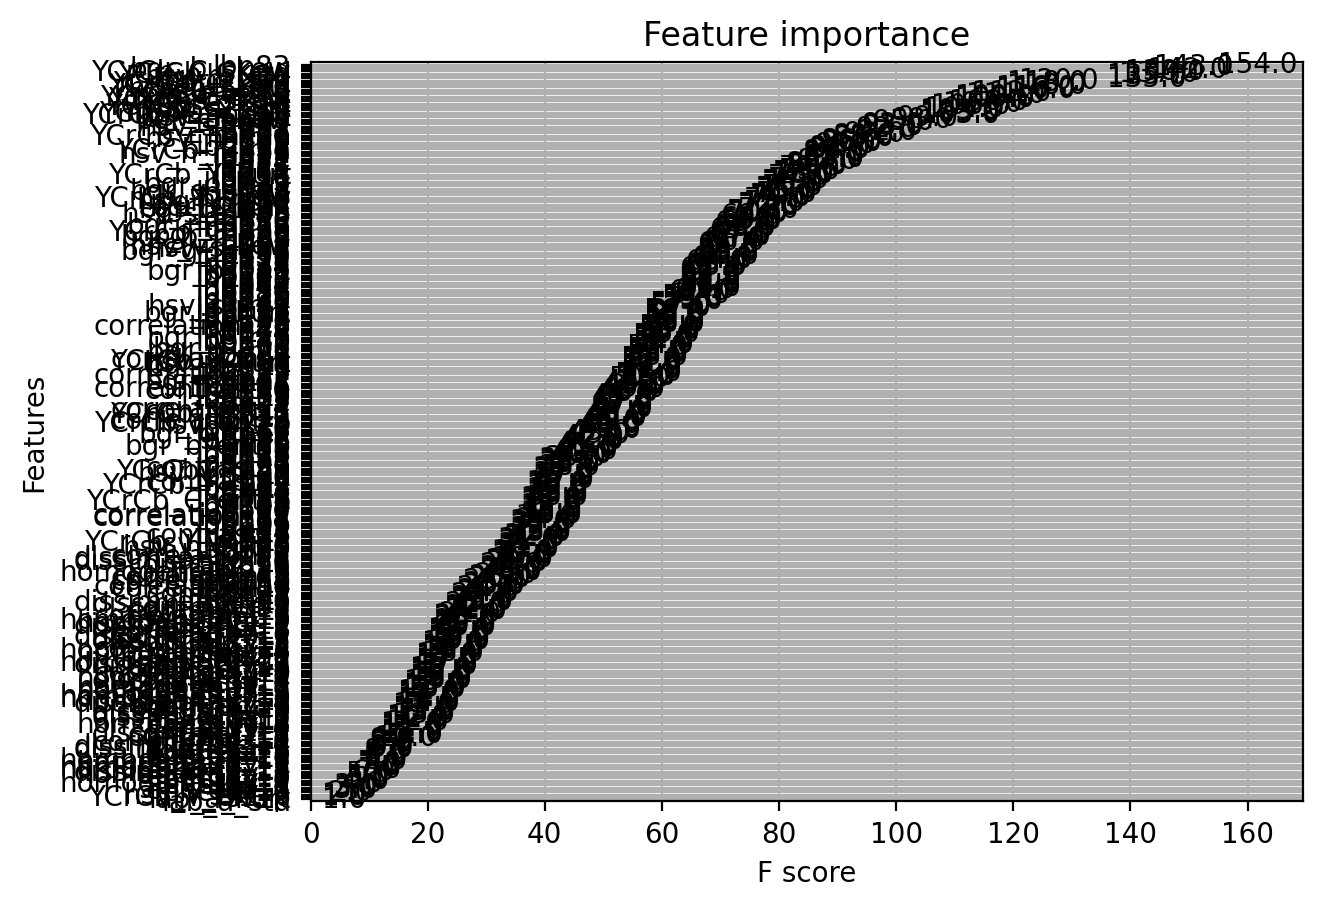

In [31]:
xgb.plot_importance(xgb_best)


In [49]:
results_dict['xgbc0']['tr']

{'iterable_parameter': nan,
 'classifier': GridSearchCV(cv=3,
              estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                      callbacks=None, colsample_bylevel=1,
                                      colsample_bynode=1, colsample_bytree=1,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric='auc', gamma=0, gpu_id=-1,
                                      grow_policy='lossguide',
                                      importance_type=None,
                                      interaction_constraints='',
                                      learning_rate=0.300000012, max_bin=256,
                                      max_c...
                          'max_cat_to_onehot': [4], 'max_delta_step': [0],
                          'max_depth': [6], 'max_leaves': [0],
                          'min_child_weight': [1], 'mi

In [41]:
from sklearn.feature_selection import SelectFromModel
# define custom class to fix bug in xgboost 1.0.2

predictions = xgb_best.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = np.sort(xgb_best.feature_importances_)
accuracies = []
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(xgb_best, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train)
	# train model
	selection_model = xgb.XGBClassifier()
	selection_model.fit(select_X_train, y_train)
	# eval model
	select_X_test = selection.transform(X_test)
	predictions = selection_model.predict(select_X_test)
	accuracy = accuracy_score(y_test, predictions)
	accuracies.append((thresh, select_X_train.shape[1], accuracy))
	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" %
	      (thresh, select_X_train.shape[1], accuracy*100.0))


Accuracy: 81.88%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=366, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=321, Accuracy: 81.30%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.001, n=320, Accuracy: 81.30%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.001, n=319, Accuracy: 81.01%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.001, n=318, Accuracy: 80.90%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.001, n=317, Accuracy: 80.35%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.001, n=316, Accuracy: 81.11%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.001, n=315, Accuracy: 81.11%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.001, n=314, Accuracy: 81.03%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.001, n=313, Accuracy: 81.56%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.001, n=312, Accuracy: 80.35%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.001, n=311, Accuracy: 80.53%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.001, n=310, Accuracy: 81.11%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.001, n=309, Accuracy: 81.03%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.001, n=308, Accuracy: 81.03%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.001, n=307, Accuracy: 80.82%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.001, n=306, Accuracy: 80.48%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.001, n=305, Accuracy: 80.48%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.001, n=304, Accuracy: 80.82%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.001, n=303, Accuracy: 80.43%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.001, n=302, Accuracy: 80.43%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=301, Accuracy: 80.43%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=300, Accuracy: 80.82%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=299, Accuracy: 80.85%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=298, Accuracy: 80.43%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=297, Accuracy: 80.58%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=296, Accuracy: 80.69%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=295, Accuracy: 80.35%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=294, Accuracy: 80.56%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=293, Accuracy: 80.61%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=292, Accuracy: 80.87%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=291, Accuracy: 80.66%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=290, Accuracy: 80.77%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=289, Accuracy: 80.77%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=288, Accuracy: 80.45%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=287, Accuracy: 80.45%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=286, Accuracy: 80.74%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=285, Accuracy: 80.48%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=284, Accuracy: 80.51%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=283, Accuracy: 80.06%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=282, Accuracy: 80.61%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=281, Accuracy: 80.98%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=280, Accuracy: 80.69%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=279, Accuracy: 81.11%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=278, Accuracy: 81.32%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=277, Accuracy: 81.77%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=276, Accuracy: 80.69%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=275, Accuracy: 81.16%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=274, Accuracy: 79.98%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=273, Accuracy: 80.87%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=272, Accuracy: 80.87%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=271, Accuracy: 80.90%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=270, Accuracy: 80.16%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=269, Accuracy: 80.72%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=268, Accuracy: 80.16%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=267, Accuracy: 80.37%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=266, Accuracy: 80.77%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=265, Accuracy: 80.43%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=264, Accuracy: 80.98%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=263, Accuracy: 80.80%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=262, Accuracy: 80.66%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=261, Accuracy: 80.66%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=260, Accuracy: 80.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=259, Accuracy: 80.11%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=258, Accuracy: 80.48%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=257, Accuracy: 80.98%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=256, Accuracy: 81.06%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=255, Accuracy: 80.80%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=254, Accuracy: 80.61%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=253, Accuracy: 80.85%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=252, Accuracy: 80.98%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=251, Accuracy: 80.66%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=250, Accuracy: 80.48%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=249, Accuracy: 80.61%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=248, Accuracy: 80.45%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=247, Accuracy: 80.77%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=246, Accuracy: 80.77%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=245, Accuracy: 80.48%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=244, Accuracy: 80.80%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=243, Accuracy: 80.35%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=242, Accuracy: 80.24%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=241, Accuracy: 80.85%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=240, Accuracy: 80.06%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=239, Accuracy: 80.45%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=238, Accuracy: 80.85%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=237, Accuracy: 80.98%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=236, Accuracy: 81.32%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=235, Accuracy: 81.32%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=234, Accuracy: 80.82%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=233, Accuracy: 80.72%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=232, Accuracy: 80.87%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=231, Accuracy: 79.95%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=230, Accuracy: 81.09%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=229, Accuracy: 81.06%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=228, Accuracy: 80.69%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=227, Accuracy: 80.56%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=226, Accuracy: 80.40%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=225, Accuracy: 80.01%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=224, Accuracy: 80.58%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=223, Accuracy: 80.48%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=222, Accuracy: 81.24%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=221, Accuracy: 80.98%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=220, Accuracy: 80.93%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=219, Accuracy: 80.27%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=218, Accuracy: 80.90%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=217, Accuracy: 80.51%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=216, Accuracy: 80.64%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=215, Accuracy: 80.64%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=214, Accuracy: 80.61%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=213, Accuracy: 80.43%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=212, Accuracy: 80.66%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=211, Accuracy: 80.72%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=210, Accuracy: 80.87%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=209, Accuracy: 81.09%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=208, Accuracy: 80.69%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=207, Accuracy: 79.98%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=206, Accuracy: 80.56%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=205, Accuracy: 80.74%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=204, Accuracy: 80.61%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=203, Accuracy: 80.40%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=202, Accuracy: 81.22%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=201, Accuracy: 80.72%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=200, Accuracy: 80.40%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=199, Accuracy: 80.77%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=198, Accuracy: 80.93%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=197, Accuracy: 81.32%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=196, Accuracy: 80.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=195, Accuracy: 81.27%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=194, Accuracy: 80.77%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=193, Accuracy: 81.01%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=192, Accuracy: 80.74%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=191, Accuracy: 80.77%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=190, Accuracy: 81.24%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=189, Accuracy: 80.35%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=188, Accuracy: 80.58%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=187, Accuracy: 80.80%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=186, Accuracy: 80.19%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=185, Accuracy: 80.98%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=184, Accuracy: 80.74%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=183, Accuracy: 81.03%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=182, Accuracy: 80.72%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=181, Accuracy: 80.98%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=180, Accuracy: 80.11%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=179, Accuracy: 81.01%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=178, Accuracy: 79.66%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=177, Accuracy: 80.24%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=176, Accuracy: 80.11%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=175, Accuracy: 80.30%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=174, Accuracy: 80.40%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=173, Accuracy: 80.51%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=172, Accuracy: 80.43%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=171, Accuracy: 79.82%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=170, Accuracy: 81.01%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=169, Accuracy: 81.16%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=168, Accuracy: 80.90%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=167, Accuracy: 80.45%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=166, Accuracy: 80.85%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=165, Accuracy: 81.01%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=164, Accuracy: 80.95%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=163, Accuracy: 81.45%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=162, Accuracy: 81.03%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=161, Accuracy: 81.51%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=160, Accuracy: 81.09%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=159, Accuracy: 81.09%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=158, Accuracy: 80.82%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=157, Accuracy: 81.59%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=156, Accuracy: 81.45%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=155, Accuracy: 80.40%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=154, Accuracy: 80.69%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=153, Accuracy: 81.40%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=152, Accuracy: 80.74%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=151, Accuracy: 80.77%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=150, Accuracy: 80.77%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=149, Accuracy: 80.72%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=148, Accuracy: 81.11%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=147, Accuracy: 80.43%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=146, Accuracy: 80.95%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=145, Accuracy: 81.51%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=144, Accuracy: 81.22%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.002, n=143, Accuracy: 81.53%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=142, Accuracy: 80.85%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=141, Accuracy: 81.09%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=140, Accuracy: 80.87%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=139, Accuracy: 81.59%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=138, Accuracy: 81.56%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=137, Accuracy: 80.90%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=136, Accuracy: 81.03%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=135, Accuracy: 81.40%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=134, Accuracy: 81.45%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=133, Accuracy: 81.38%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=132, Accuracy: 81.30%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=131, Accuracy: 81.30%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=130, Accuracy: 81.51%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=129, Accuracy: 80.98%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=128, Accuracy: 81.11%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=127, Accuracy: 81.56%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=126, Accuracy: 80.74%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=125, Accuracy: 80.87%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=124, Accuracy: 80.77%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=123, Accuracy: 80.66%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=122, Accuracy: 80.98%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=121, Accuracy: 81.59%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=120, Accuracy: 81.16%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=119, Accuracy: 80.90%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=118, Accuracy: 80.95%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=117, Accuracy: 81.40%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=116, Accuracy: 80.69%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=115, Accuracy: 81.01%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=114, Accuracy: 81.69%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=113, Accuracy: 81.06%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=112, Accuracy: 80.66%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=111, Accuracy: 81.45%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=110, Accuracy: 81.27%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=109, Accuracy: 81.14%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=108, Accuracy: 81.51%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=107, Accuracy: 81.77%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=106, Accuracy: 81.03%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=105, Accuracy: 80.80%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=104, Accuracy: 80.40%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=103, Accuracy: 80.40%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=102, Accuracy: 81.16%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=101, Accuracy: 81.40%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=100, Accuracy: 80.98%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=99, Accuracy: 80.87%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=98, Accuracy: 80.48%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=97, Accuracy: 81.35%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=96, Accuracy: 81.38%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=95, Accuracy: 81.01%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=94, Accuracy: 82.11%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=93, Accuracy: 80.95%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=92, Accuracy: 81.66%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=91, Accuracy: 81.35%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=90, Accuracy: 81.61%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=89, Accuracy: 80.98%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=88, Accuracy: 80.90%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=87, Accuracy: 81.09%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=86, Accuracy: 80.74%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=85, Accuracy: 81.32%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=84, Accuracy: 81.06%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=83, Accuracy: 80.77%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=82, Accuracy: 80.45%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=81, Accuracy: 80.82%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=80, Accuracy: 81.45%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=79, Accuracy: 81.38%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=78, Accuracy: 81.06%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=77, Accuracy: 80.72%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=76, Accuracy: 80.85%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=75, Accuracy: 80.85%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=74, Accuracy: 81.38%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=73, Accuracy: 80.66%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=72, Accuracy: 80.48%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=71, Accuracy: 80.98%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=70, Accuracy: 80.45%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=69, Accuracy: 80.30%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=68, Accuracy: 80.48%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=67, Accuracy: 80.32%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=66, Accuracy: 80.93%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=65, Accuracy: 80.37%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=64, Accuracy: 80.98%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=63, Accuracy: 80.87%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=62, Accuracy: 79.87%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=61, Accuracy: 81.22%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=60, Accuracy: 80.80%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=59, Accuracy: 80.66%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=58, Accuracy: 80.01%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.003, n=57, Accuracy: 80.61%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.004, n=56, Accuracy: 80.40%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.004, n=55, Accuracy: 80.45%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.004, n=54, Accuracy: 80.66%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.004, n=53, Accuracy: 80.37%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.004, n=52, Accuracy: 80.61%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.004, n=51, Accuracy: 80.72%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.004, n=50, Accuracy: 80.66%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.004, n=49, Accuracy: 79.82%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.004, n=48, Accuracy: 79.74%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.004, n=47, Accuracy: 80.87%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.004, n=46, Accuracy: 79.95%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.004, n=45, Accuracy: 80.11%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.004, n=44, Accuracy: 80.08%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.004, n=43, Accuracy: 80.22%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.004, n=42, Accuracy: 80.56%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.004, n=41, Accuracy: 79.72%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.004, n=40, Accuracy: 79.61%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.004, n=39, Accuracy: 79.35%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.004, n=38, Accuracy: 79.32%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.004, n=37, Accuracy: 79.85%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.004, n=36, Accuracy: 79.61%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.004, n=35, Accuracy: 79.61%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.004, n=34, Accuracy: 79.19%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.004, n=33, Accuracy: 79.40%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.004, n=32, Accuracy: 79.00%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.004, n=31, Accuracy: 78.56%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.004, n=30, Accuracy: 78.56%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.004, n=29, Accuracy: 79.03%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.004, n=28, Accuracy: 78.50%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.004, n=27, Accuracy: 78.32%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.004, n=26, Accuracy: 78.13%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.004, n=25, Accuracy: 78.37%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.004, n=24, Accuracy: 78.71%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.005, n=23, Accuracy: 77.79%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.005, n=22, Accuracy: 77.71%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.005, n=21, Accuracy: 78.21%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.005, n=20, Accuracy: 78.21%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.005, n=19, Accuracy: 78.45%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.005, n=18, Accuracy: 78.11%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.005, n=17, Accuracy: 77.77%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.005, n=16, Accuracy: 77.69%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.005, n=15, Accuracy: 78.06%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.005, n=14, Accuracy: 78.03%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.006, n=13, Accuracy: 77.58%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.006, n=12, Accuracy: 76.90%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.006, n=11, Accuracy: 76.63%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.007, n=10, Accuracy: 76.32%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.007, n=9, Accuracy: 74.97%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.007, n=8, Accuracy: 74.92%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.010, n=7, Accuracy: 74.37%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.014, n=6, Accuracy: 75.47%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.014, n=5, Accuracy: 75.11%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.016, n=4, Accuracy: 73.74%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.020, n=3, Accuracy: 70.86%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.022, n=2, Accuracy: 69.20%
Thresh=0.088, n=1, Accuracy: 67.26%


/Users/manasikattel/miniforge3/envs/cad/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [48]:
np.amax(np.array(accuracies),axis=0)

array([8.76543000e-02, 3.66000000e+02, 8.21127503e-01])

# TRY SVM with increased LBP/GLCM features